# GMIT HDip Data Analytics; Machine Learning and Statistics; Project  
Read data from a csv file containing two values - speed and power - for the power generated by a wind turbine according to wind speed. 

Let a user input wind speeds, and provide predictions of expected power.  

Start by reading in the csv file [1] and looking at the data:  
[1] Load data from txt with Pandas ; https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('powerproduction.txt', sep=",")

print(df)

      speed  power
0     0.000    0.0
1     0.125    0.0
2     0.150    0.0
3     0.225    0.0
4     0.275    0.0
..      ...    ...
495  24.775    0.0
496  24.850    0.0
497  24.875    0.0
498  24.950    0.0
499  25.000    0.0

[500 rows x 2 columns]


The first and last few entries all have power 0.0. Check some values from the middle of the data set :

In [4]:
print(df[245:255])

      speed   power
245  12.387  37.159
246  12.412  52.952
247  12.462  44.745
248  12.487  44.735
249  12.538  44.801
250  12.563  42.336
251  12.588  54.079
252  12.613  51.471
253  12.663  44.880
254  12.713  51.149


Plot the data using Seaborn, to get a visual image of it [2] :  
[2] Week 4 notes, Models, Train; GMIT Data Analytics HDip ; Machine Learning and Statistics notes

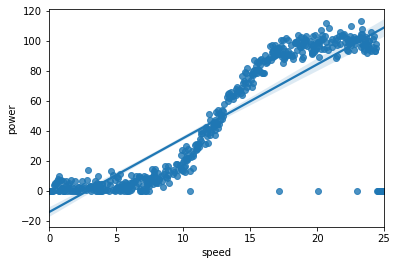

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x='speed',y='power',data=df)
plt.show()

The straight line doesn't provide a great fit to the data. See if specifying 'order' (to apply a polynomial of higher order) 
gives a better fit [3] :   
[3] Fitting different kinds of models; https://seaborn.pydata.org/tutorial/regression.html

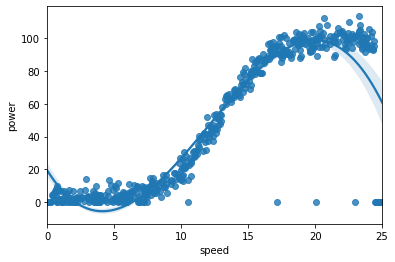

In [10]:
sns.regplot(x='speed',y='power',data=df, order=3)
plt.show()